In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [23]:
from diffusers import AutoPipelineForText2Image

In [24]:
import torch

In [25]:
assert torch.cuda.is_available()

In [26]:
from PIL import Image
from PIL.Image import Dither

In [27]:
import numpy as np

## Load pipe

In [28]:
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Selecting a bad prompt
Select a prompt that will generate a picture with lots of "grey" area

In [32]:
prompt = "mysterious forest, portrait of big creature, big smile, Thomas Nast"

In [33]:
image = pipe(
        prompt,
        num_inference_steps=1,
        guidance_scale=0.0,
        num_images_per_prompt=1,
        width=960,
        height=680
    ).images[0]

  0%|          | 0/1 [00:00<?, ?it/s]

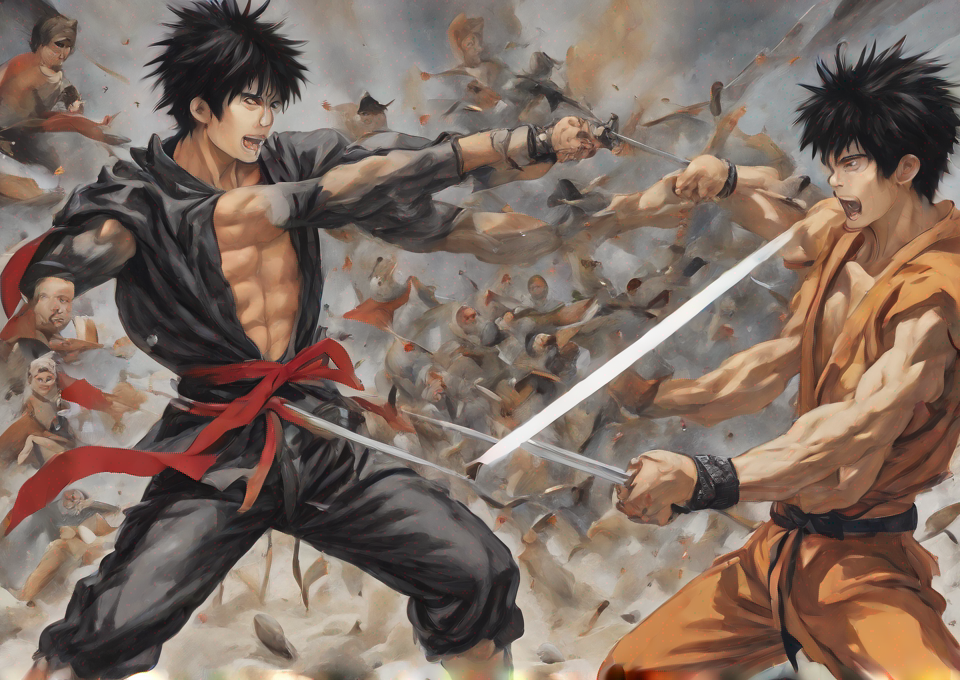

In [34]:
image

## Try dithering and send to 

In [ ]:
# Default dithering for PIL is Floyd-steinberg
image_f = image.convert("1", dither=Dither.FLOYDSTEINBERG)
image_f

In [ ]:
def atkinson(image: Image.Image):

    frac = 8 # Atkinson constant
    neighbours = [(1, 0), (2, 0), (-1, 1), (0, 1), (1, 1), (0, 2)]
    img = np.array(image.convert("L"), dtype=np.int32)
    
    threshold = np.zeros(256, dtype=np.int32)
    threshold[128:] = 255
    
    height, width = img.shape
    
    for y in range(height):
        for x in range(width):
            
            old = img[y, x]
            old = np.min([old, 255])
            new = threshold[old]
            err = (old - new) // frac
            
            img[y, x] = new

            for dx, dy in neighbours:
                nx, ny = x + dx, y + dy
                
                if 0 <= nx < width and 0 <= ny < height:

                    # Make sure that img set is between 0 and 255 (negative error could surpass the value)
                    img[ny, nx] = np.clip(img[ny, nx] + err, 0, 255)
    
    return Image.fromarray(np.uint8(img))

In [ ]:
image_a = atkinson(image)

In [ ]:
image_a

## Compare in one photo

In [ ]:
# Get dimensions
width, height = image.size

# Find center
center_x = int(width/2)
center_y = int(height/2)

# Split two images
a = image_f.crop((0, 0, center_x, height))
b = image_a.crop((center_x, 0, width, height))

# Merge into one
image_m = image.copy()
image_m.paste(a, (0,0))
image_m.paste(b, (center_x,0))

In [ ]:
image_m

# Test by sending to photo

In [ ]:
from art_utils import network_utils

In [ ]:
# r = network_utils.send_photo(image_m, "http://192.168.1.26:8080/display/bitmap")
# r